In [5]:
import pandas as pd

train_data = pd.read_csv('./data/663e2b6d54457_train_data_with_samplefeatures.csv')
match_data = pd.read_csv('./data/664389efa0868_match_level_scorecard.csv')
bowlers_data = pd.read_csv('./data/663e2b2c60743_bowler_level_scorecard.csv')
batsman_data = pd.read_csv('./data/663e2b548c98c_batsman_level_scorecard.csv')
test_data = pd.read_csv('./data/6644a1e287df6_test_data_with_samplefeatures.csv')

train_data = train_data.sort_values('match_dt')
match_data = match_data.sort_values('match_dt')
bowlers_data = bowlers_data.sort_values('match_dt')
batsman_data = batsman_data.sort_values('match_dt')
test_data = test_data.sort_values('match_dt')

In [6]:
import pandas as pd

def get_player_stats(match_data, batsman_data, bowlers_data):
    def getifbatsman(batting_id):
        return batting_id in batsman_data['batsman_id'].values

    def getifbowler(bowling_id):
        return bowling_id in bowlers_data['bowler_id'].values
    
    def get_avg_stats(player_data, columns, n):
        avg_stats = {col: player_data[col].tail(n).mean() for col in columns}
        return {col: (0 if pd.isna(val) else val) for col, val in avg_stats.items()}

    # Convert match_dt column to datetime
    batsman_data['match_dt'] = pd.to_datetime(batsman_data['match_dt'])
    bowlers_data['match_dt'] = pd.to_datetime(bowlers_data['match_dt'])
    
    # Extract reference match details
    team1 = [int(float(id)) for id in match_data['team1_roster_ids'].split(':')]
    team2 = [int(float(id)) for id in match_data['team2_roster_ids'].split(':')]
    match_dt = pd.to_datetime(match_data['match_dt'])
    
    team1_batsman = [player for player in team1 if getifbatsman(player)]
    team1_bowlers = [player for player in team1 if getifbowler(player)]
    team2_batsman = [player for player in team2 if getifbatsman(player)]
    team2_bowlers = [player for player in team2 if getifbowler(player)]
    
    batsman_stats_columns = ['runs', 'balls_faced', 'Fours', 'Sixes', 'strike_rate']
    bowler_stats_columns = ['wicket_count', 'runs', 'balls_bowled', 'economy']
    
    stats = {
        'team1': {
            'batsman': {},
            'bowlers': {}
        },
        'team2': {
            'batsman': {},
            'bowlers': {}
        }
    }

    team1_players_stats = []
    team2_players_stats = []
    
    for batsman in team1_batsman:
        k = batsman_data[(batsman_data['batsman_id'] == batsman) & (batsman_data['match_dt'] < match_dt)]
        n = min(5, len(k))
        batsman_stats = get_avg_stats(k, batsman_stats_columns, n)
        stats['team1']['batsman'][batsman] = batsman_stats
        team1_players_stats.append(batsman_stats)
    
    for bowler in team1_bowlers:
        l = bowlers_data[(bowlers_data['bowler_id'] == bowler) & (bowlers_data['match_dt'] < match_dt)]
        n = min(5, len(l))
        bowler_stats = get_avg_stats(l, bowler_stats_columns, n)
        stats['team1']['bowlers'][bowler] = bowler_stats
        team1_players_stats.append(bowler_stats)
    
    for batsman in team2_batsman:
        k = batsman_data[(batsman_data['batsman_id'] == batsman) & (batsman_data['match_dt'] < match_dt)]
        n = min(5, len(k))
        batsman_stats = get_avg_stats(k, batsman_stats_columns, n)
        stats['team2']['batsman'][batsman] = batsman_stats
        team2_players_stats.append(batsman_stats)
    
    for bowler in team2_bowlers:
        l = bowlers_data[(bowlers_data['bowler_id'] == bowler) & (bowlers_data['match_dt'] < match_dt)]
        n = min(5, len(l))
        bowler_stats = get_avg_stats(l, bowler_stats_columns, n)
        stats['team2']['bowlers'][bowler] = bowler_stats
        team2_players_stats.append(bowler_stats)
    
    # Calculate average of all players for each team
    def calculate_team_avg_stats(players_stats, columns):
        avg_stats = {}
        num_players = len(players_stats)
        if num_players > 0:
            for column in columns:
                column_values = [player_stats.get(column, 0) for player_stats in players_stats]
                avg_stats[column] = sum(column_values) / num_players
        return avg_stats, num_players

    avg_team1_batsmen, num_team1_batsmen = calculate_team_avg_stats(team1_players_stats, batsman_stats_columns)
    avg_team1_bowlers, num_team1_bowlers = calculate_team_avg_stats(team1_players_stats, bowler_stats_columns)

    avg_team2_batsmen, num_team2_batsmen = calculate_team_avg_stats(team2_players_stats, batsman_stats_columns)
    avg_team2_bowlers, num_team2_bowlers = calculate_team_avg_stats(team2_players_stats, bowler_stats_columns)

    return {
        'individual_stats': stats,
        'team1_avg': {
            'batsmen': avg_team1_batsmen,
            'bowlers': avg_team1_bowlers,
            'num_batsmen': num_team1_batsmen,
            'num_bowlers': num_team1_bowlers
        },
        'team2_avg': {
            'batsmen': avg_team2_batsmen,
            'bowlers': avg_team2_bowlers,
            'num_batsmen': num_team2_batsmen,
            'num_bowlers': num_team2_bowlers
        }
    }


In [7]:
df = []

for i in range(len(train_data)):
    x = train_data.iloc[i]
    player_stats = get_player_stats(x, batsman_data, bowlers_data)
    df.append(
        {
            'team1_batsman_avg_runs': player_stats['team1_avg']['batsmen']['runs'],
            'team1_batsman_avg_balls_faced': player_stats['team1_avg']['batsmen']['balls_faced'],
            'team1_batsman_avg_Fours': player_stats['team1_avg']['batsmen']['Fours'],
            'team1_batsman_avg_Sixes': player_stats['team1_avg']['batsmen']['Sixes'],
            'team1_batsman_avg_strike_rate': player_stats['team1_avg']['batsmen']['strike_rate'],
            'team1_bowler_avg_wicket_count': player_stats['team1_avg']['bowlers']['wicket_count'],
            'team1_bowler_avg_runs': player_stats['team1_avg']['bowlers']['runs'],
            'team1_bowler_avg_balls_bowled': player_stats['team1_avg']['bowlers']['balls_bowled'],
            'team1_bowler_avg_economy': player_stats['team1_avg']['bowlers']['economy'],
            'team1_batsmen_count': player_stats['team1_avg']['num_batsmen'],
            'team1_bowlers_count': player_stats['team1_avg']['num_bowlers'],
            'team2_batsman_avg_runs': player_stats['team2_avg']['batsmen']['runs'],
            'team2_batsman_avg_balls_faced': player_stats['team2_avg']['batsmen']['balls_faced'],
            'team2_batsman_avg_Fours': player_stats['team2_avg']['batsmen']['Fours'],
            'team2_batsman_avg_Sixes': player_stats['team2_avg']['batsmen']['Sixes'],
            'team2_batsman_avg_strike_rate': player_stats['team2_avg']['batsmen']['strike_rate'],
            'team2_bowler_avg_wicket_count': player_stats['team2_avg']['bowlers']['wicket_count'],
            'team2_bowler_avg_runs': player_stats['team2_avg']['bowlers']['runs'],
            'team2_bowler_avg_balls_bowled': player_stats['team2_avg']['bowlers']['balls_bowled'],
            'team2_bowler_avg_economy': player_stats['team2_avg']['bowlers']['economy'],
            'team2_batsmen_count': player_stats['team2_avg']['num_batsmen'],
            'team2_bowlers_count': player_stats['team2_avg']['num_bowlers'],
            'winner' : 1 if x['team1'] == x['winner'] else 0,
            'team_count_50runs_last15' : x['team_count_50runs_last15'],
            'team_winp_last5' : x['team_winp_last5'],
            'team1only_avg_runs_last15' : x['team1only_avg_runs_last15'],
            'team1_winp_team2_last15' : x['team1_winp_team2_last15'],
            'ground_avg_runs_last15' : x['ground_avg_runs_last15'],
        }
    )

- If team1 won -- 1
- If team2 won -- 0

In [13]:
df = pd.DataFrame(df)
df.fillna(0, inplace=True)

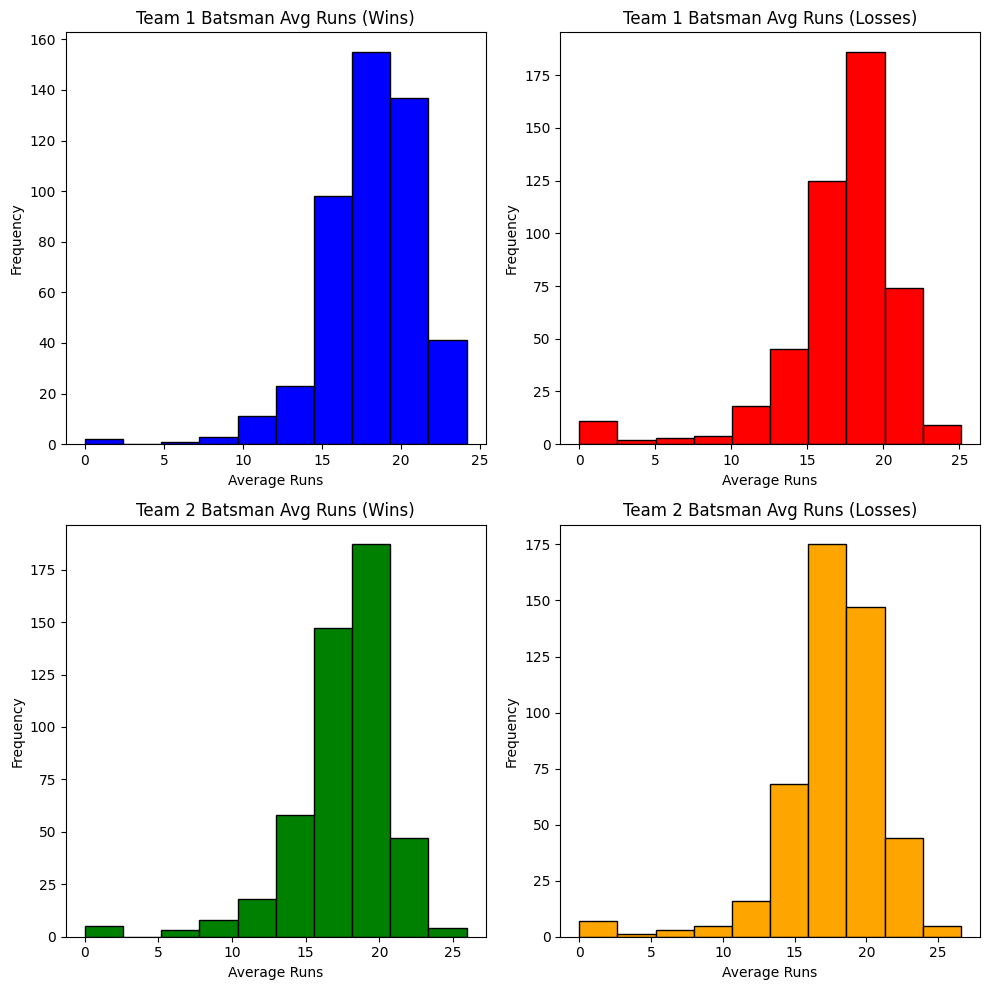

In [16]:
import matplotlib.pyplot as plt

# Separate the data for team 1 into wins and losses
df_team1_wins = df[df['winner'] == 1]
df_team1_losses = df[df['winner'] == 0]

# Separate the data for team 2 into wins and losses
df_team2_wins = df[df['winner'] == 0]
df_team2_losses = df[df['winner'] == 1]

# Plot histograms for team 1
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.hist(df_team1_wins['team1_batsman_avg_runs'], bins=10, color='blue', edgecolor='black')
plt.title('Team 1 Batsman Avg Runs (Wins)')
plt.xlabel('Average Runs')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(df_team1_losses['team1_batsman_avg_runs'], bins=10, color='red', edgecolor='black')
plt.title('Team 1 Batsman Avg Runs (Losses)')
plt.xlabel('Average Runs')
plt.ylabel('Frequency')

# Plot histograms for team 2
plt.subplot(2, 2, 3)
plt.hist(df_team2_wins['team2_batsman_avg_runs'], bins=10, color='green', edgecolor='black')
plt.title('Team 2 Batsman Avg Runs (Wins)')
plt.xlabel('Average Runs')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(df_team2_losses['team2_batsman_avg_runs'], bins=10, color='orange', edgecolor='black')
plt.title('Team 2 Batsman Avg Runs (Losses)')
plt.xlabel('Average Runs')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [18]:
df['avg_batsman_runs_diff'] = df['team1_batsman_avg_runs'] - df['team2_batsman_avg_runs']

In [23]:
df_selected = df[['winner', 'avg_batsman_runs_diff']]

df_selected

,winner,avg_batsman_runs_diff
0,1,-1.912963
1,1,5.109942
2,0,1.309788
3,0,2.595098
4,0,-10.086415
...,...,...
943,0,0.407703
944,0,2.276852
945,0,0.292083
946,0,0.303922


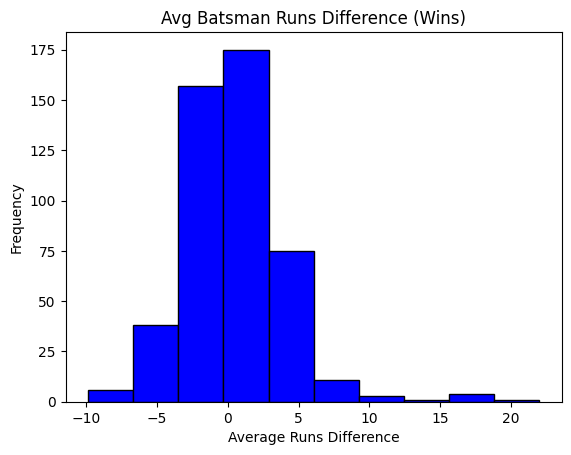

In [24]:
## Histogram when winner = 1, distribution of avg_batsman_runs_diff
plt.hist(df_selected[df_selected['winner'] == 1]['avg_batsman_runs_diff'], bins=10, color='blue', edgecolor='black')
plt.title('Avg Batsman Runs Difference (Wins)')
plt.xlabel('Average Runs Difference')
plt.ylabel('Frequency')
plt.show()

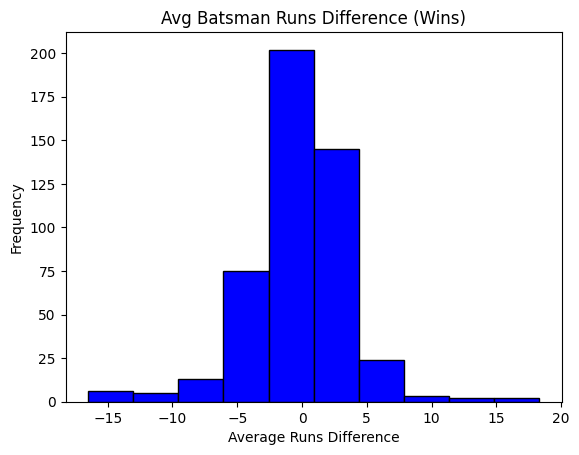

In [25]:
## Histogram when winner = 1, distribution of avg_batsman_runs_diff
plt.hist(df_selected[df_selected['winner'] == 0]['avg_batsman_runs_diff'], bins=10, color='blue', edgecolor='black')
plt.title('Avg Batsman Runs Difference (Wins)')
plt.xlabel('Average Runs Difference')
plt.ylabel('Frequency')
plt.show()

In [26]:
## mean of avg_batsman_runs_diff when winner = 1
df_selected[df_selected['winner'] == 1]['avg_batsman_runs_diff'].mean()


0.47259665278630625

In [27]:
## mean of avg_batsman_runs_diff when winner = 0
df_selected[df_selected['winner'] == 0]['avg_batsman_runs_diff'].mean()

-0.30469894531159314

In [38]:
## Percentage of times team1 wins when avg_batsman_runs_diff is positive
df_selected[(df_selected['avg_batsman_runs_diff'] > -2) & (df_selected['winner'] == 1)].shape[0] / df_selected[df_selected['avg_batsman_runs_diff'] > 0].shape[0]

0.7626050420168067

In [36]:
## Percentage of times team2 wins when avg_batsman_runs_diff is negative
df_selected[(df_selected['avg_batsman_runs_diff'] < 2) & (df_selected['winner'] == 0)].shape[0] / df_selected[df_selected['avg_batsman_runs_diff'] < 0].shape[0]

0.776595744680851

## team1_bowler_avg_wicket_count

In [39]:
df['avg_wicket_count_diff'] = df['team1_bowler_avg_wicket_count'] - df['team2_bowler_avg_wicket_count']

In [42]:
df_selected = df[['winner', 'avg_batsman_runs_diff', 'avg_wicket_count_diff']]

df_selected

,winner,avg_batsman_runs_diff,avg_wicket_count_diff
0,1,-1.912963,0.000000
1,1,5.109942,0.135673
2,0,1.309788,0.057143
3,0,2.595098,0.046233
4,0,-10.086415,-0.357049
...,...,...,...
943,0,0.407703,0.276751
944,0,2.276852,-0.254444
945,0,0.292083,0.062500
946,0,0.303922,0.017647
